In [36]:
import numpy as np
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from IPython.display import display, HTML
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer, StandardScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture as GMM
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import FastICA

from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from collections import defaultdict
from itertools import product
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.ensemble import RandomForestClassifier

In [7]:
def load_data(clean=False):
    data_directory = "data/"
    filename = "diabetes.csv"
    df = pd.read_csv(data_directory + filename)
    if clean:
        df = df[df['SkinThickness'] > 0]
        df = df[df['Insulin'] > 0]
    #plt.show()
    cols = list(df.columns.values)
    cols.remove('Outcome')
    X = (df[cols]).values
    y = df['Outcome'].values
    if clean:
        X = StandardScaler().fit_transform(X)
    #scaler = StandardScaler()
    #scaler.fit(X)
    #X = scaler.transform(X)
    
    #plt.savefig("./output/label_count_mnist.png")
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)


In [58]:
def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):
    

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    

def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6]):
    aics = []
    bics = []
    scores = []
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    plt.title ("AIC/BIC elbow method per n_clusters")
    plt.show()

    
    
def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(vals_range, X, y):
    result_dfs = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        components = pca.fit_transform(X)

        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)
        
        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    return result_dfs

def pca_comparison(X, n_components):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
    plt.show()
    plt.clf()
    
def analyze_ica(X, n_comps):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X)
    X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('ic 1', fontsize = 15)
    ax.set_ylabel('ic 2', fontsize = 15)
    ax.set_title('ICA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        points_in_label = icaDf['labels'] == target
        ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                   , icaDf.loc[points_in_label, 'ic 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('ic 1', fontsize = 15)
    ax.set_ylabel('ic 2', fontsize = 15)
    ax.set_zlabel('ic 3', fontsize = 15)
    ax.set_title('ICA', fontsize = 20)
    targets = [0, 1]
    colors = ['g', 'r']
    for target, color in zip(targets,colors):
        points_in_label = icaDf['labels'] == target
        ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                   , icaDf.loc[points_in_label, 'ic 2']
                   , icaDf.loc[points_in_label, 'ic 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    #ax.set_ylim(-1, 1)
    ax.grid()
    
    return icaDf

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    #dims = list(np.arange(2,80,3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        print(dim)
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_SparseRandomProjection(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    #dims = list(np.arange(2,80,3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        #print(i)
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    print(tmp)
    tmp = pd.DataFrame(tmp).T
    print(tmp)
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def RFC_features(X, y, columns, threshold=0.8):
    X_copy = X.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X, y)
    for name, importance in zip(df.columns[:-1], rnd_clf.feature_importances_):
        print(name, "=", importance)
    indices = np.argsort(rnd_clf.feature_importances_)
    print(indices)
    plt.title('Feature Importances')
    cumsum = 0
    useful_indices = []
    i = 0
    while i < len(indices):
        if cumsum < .8:
            cumsum += rnd_clf.feature_importances_[i]
            #print(cumsum)
            useful_indices.append(indices[i])
        i+=1
    print(useful_indices)
    print(columns[useful_indices])
    plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [df.columns[:-1][i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return(X_copy)

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)


In [24]:
np.random.seed(0)

In [25]:
X, y = load_data(clean=True)

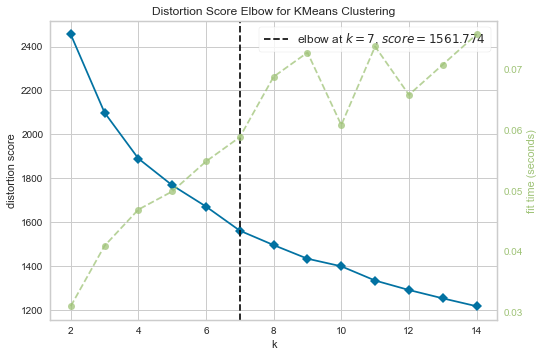

In [26]:
k_means_elbow_viz(X, k_range=(2, 15))

For n_clusters = 2 The average silhouette_score is : 0.2398460639116155
For n_clusters = 3 The average silhouette_score is : 0.21038601796366543
For n_clusters = 4 The average silhouette_score is : 0.2031293662011789
For n_clusters = 5 The average silhouette_score is : 0.15467168998367087
For n_clusters = 6 The average silhouette_score is : 0.15092385134030312
For n_clusters = 7 The average silhouette_score is : 0.1676753107386964
For n_clusters = 8 The average silhouette_score is : 0.16105709212562488
For n_clusters = 9 The average silhouette_score is : 0.14459146288339755
For n_clusters = 10 The average silhouette_score is : 0.14031787808047672


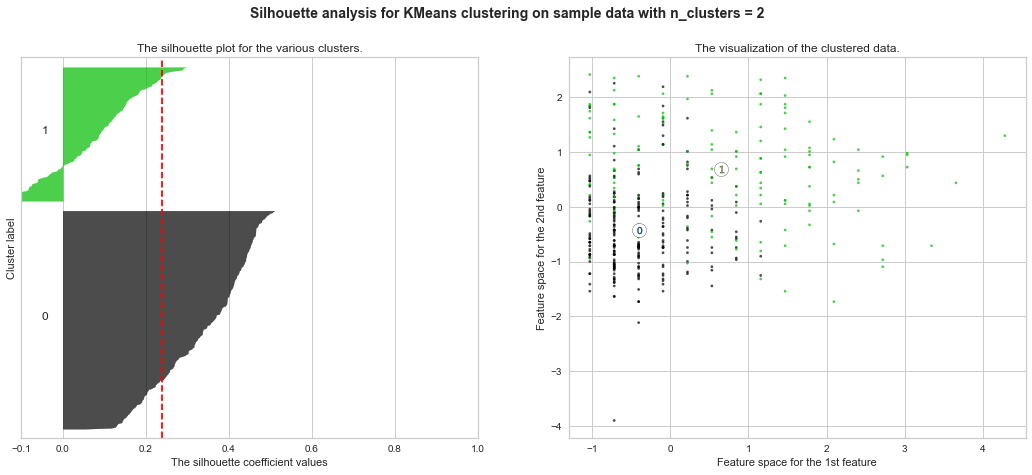

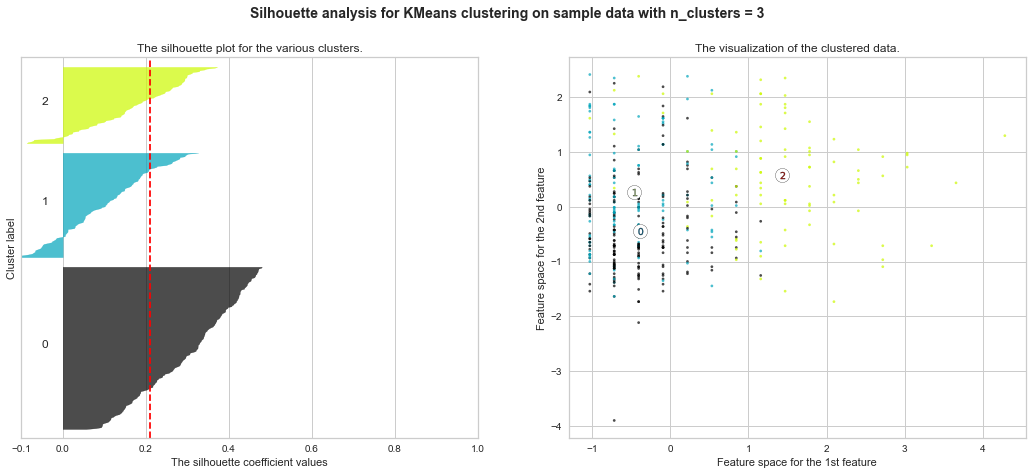

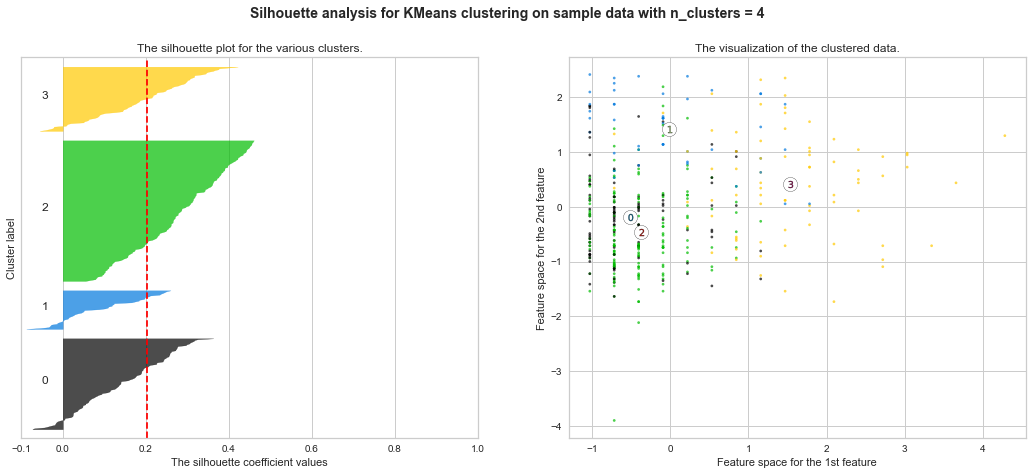

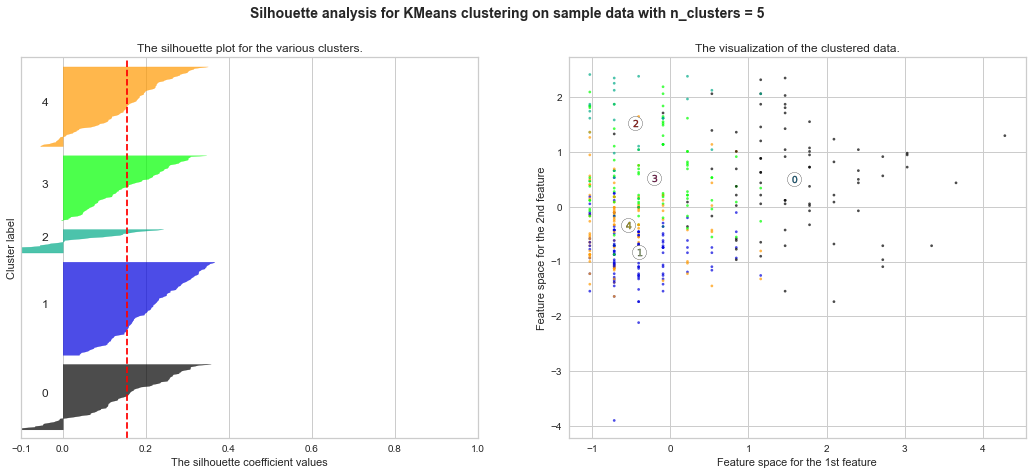

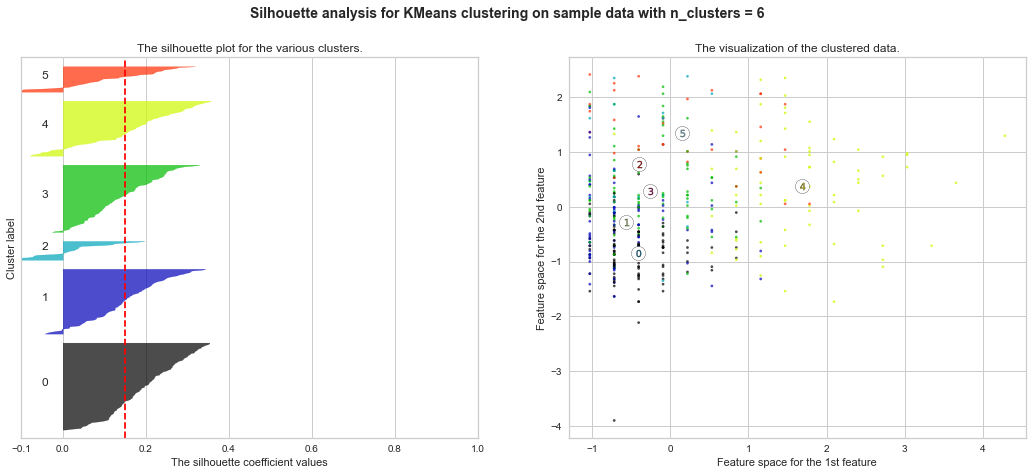

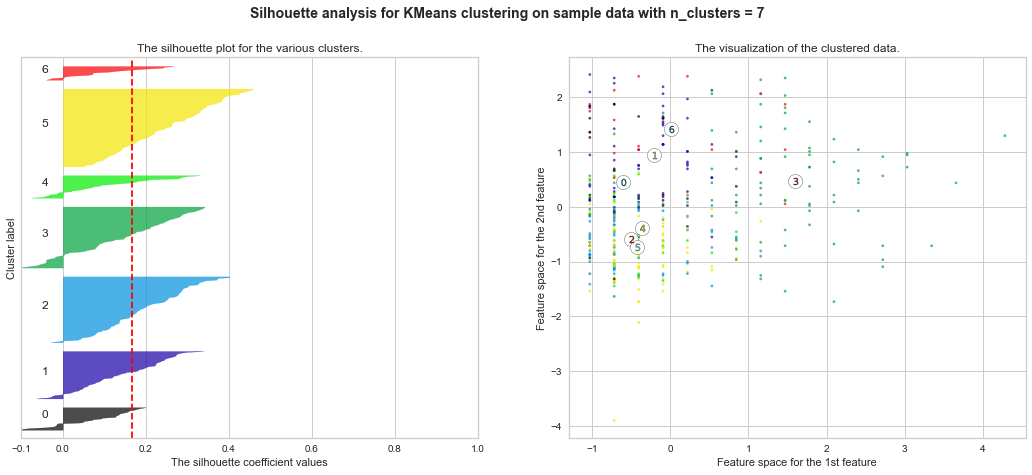

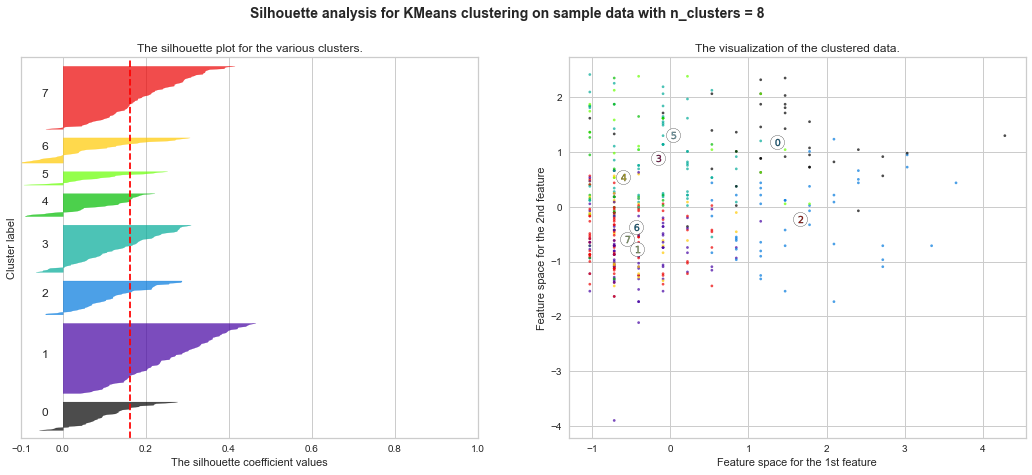

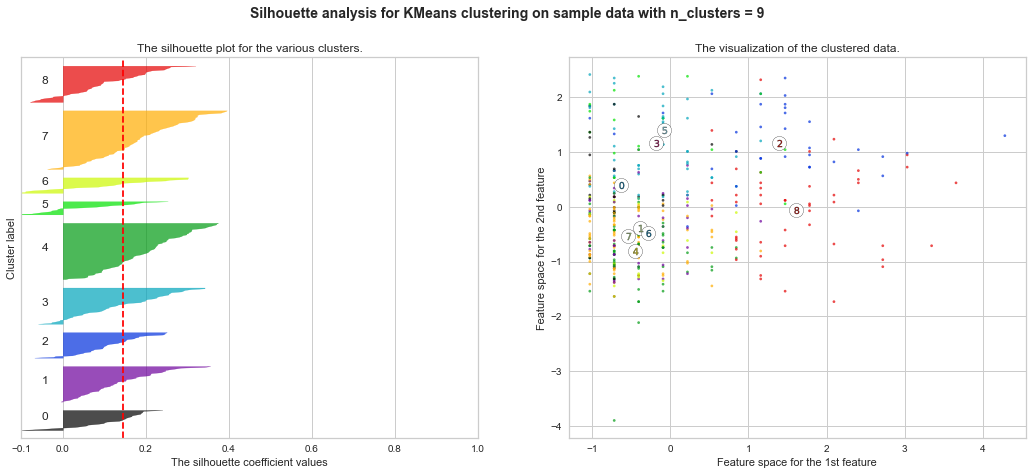

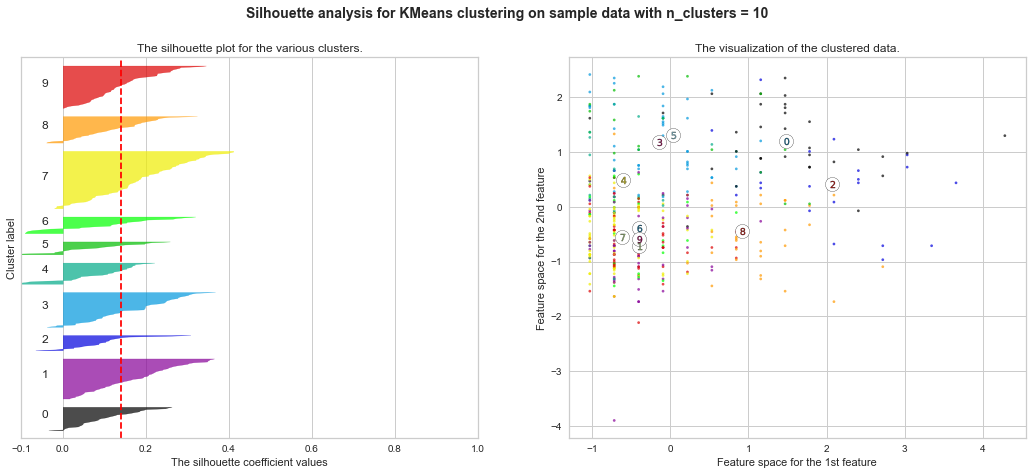

In [27]:
k_means_silhouette(X)

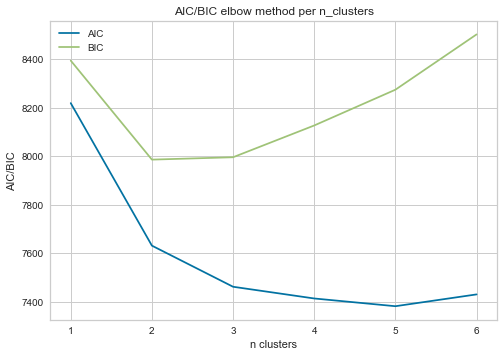

In [28]:
GMM_elbow(X, y)

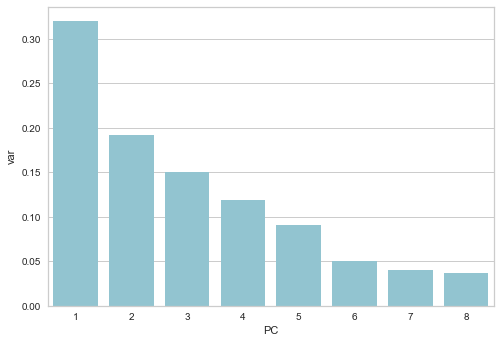

<Figure size 576x396 with 0 Axes>

In [29]:
pca_comparison(X, 8)

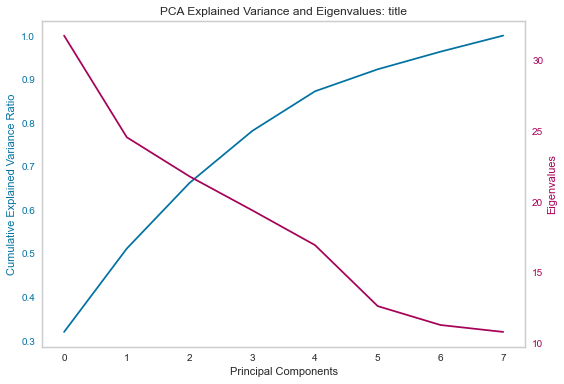

In [30]:
run_PCA(X, y, "title")

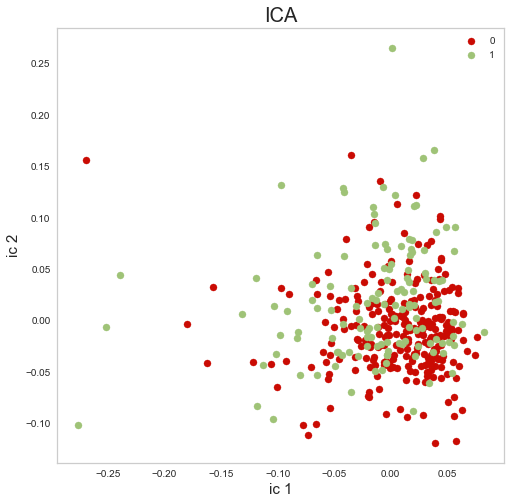

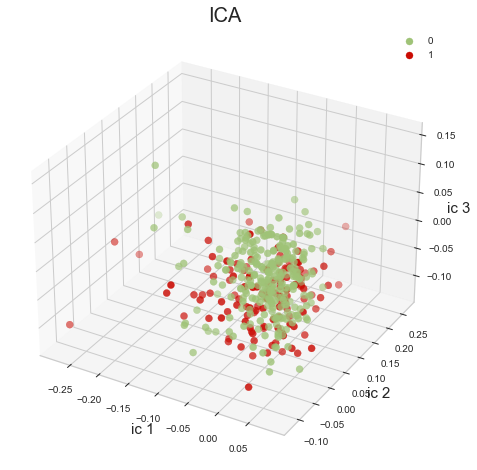

In [31]:
icaDf = analyze_ica(X, 5)

defaultdict(<class 'dict'>, {2: {0: 0.5393658517662105, 1: 0.6251431189656859, 2: 0.4684405666337479, 3: 0.7085845893051403, 4: 0.6704147948464763}, 5: {0: 0.8042036276633273, 1: 0.8188467202377282, 2: 0.8324027762567392, 3: 0.8647767845869959, 4: 0.7583140292260359}, 8: {0: 0.8095755907648594, 1: 0.8908880386176921, 2: 0.8479008295743858, 3: 0.8402249575647873, 4: 0.8955679737117169}})
          0         1         2         3         4
2  0.539366  0.625143  0.468441  0.708585  0.670415
5  0.804204  0.818847  0.832403  0.864777  0.758314
8  0.809576  0.890888  0.847901  0.840225  0.895568


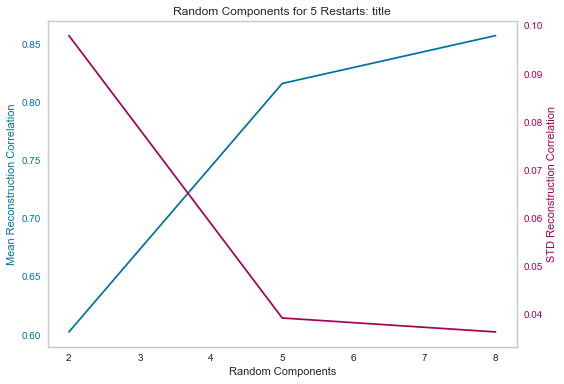

In [34]:
run_SparseRandomProjection(X, y, "title")

In [37]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [42]:

data_directory = "data/"
filename = "diabetes.csv"
df = pd.read_csv(data_directory + filename)
print(df.columns[:-1].shape)

(8,)


In [43]:
rnd_clf.feature_importances_

array([0.08209156, 0.24471049, 0.0723132 , 0.08414884, 0.15307176,
       0.11815377, 0.10779989, 0.1377105 ])

In [44]:
for name, importance in zip(df.columns[:-1], rnd_clf.feature_importances_):
    print(name, "=", importance)

Pregnancies = 0.08209155606222784
Glucose = 0.24471048894458444
BloodPressure = 0.07231320376520889
SkinThickness = 0.08414883587717652
Insulin = 0.15307175981496254
BMI = 0.11815376747086946
DiabetesPedigreeFunction = 0.10779988897832923
Age = 0.13771049908664112


[2 0 3 6 5 7 4 1]
0.08209155606222784
0.3268020450068123
0.3991152487720212
0.48326408464919773
0.6363358444641602
0.7544896119350297
0.862289500913359
[2, 0, 3, 6, 5, 7, 4]


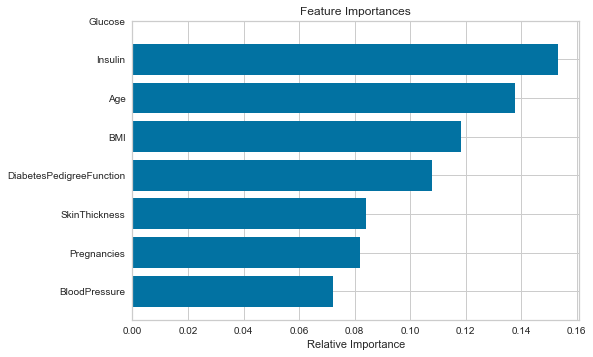

In [56]:
indices = np.argsort(rnd_clf.feature_importances_)
print(indices)
plt.title('Feature Importances')
cumsum = 0
useful_indices = []
i = 0
while cumsum < .8:
    cumsum += rnd_clf.feature_importances_[i]
    print(cumsum)
    useful_indices.append(indices[i])
    i+=1
print(useful_indices)    
plt.barh(range(len(useful_indices)), rnd_clf.feature_importances_[useful_indices], color='b', align='center')
plt.yticks(range(len(indices)), [df.columns[:-1][i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

(394, 8)
Pregnancies = 0.08209155606222784
Glucose = 0.24471048894458444
BloodPressure = 0.07231320376520889
SkinThickness = 0.08414883587717652
Insulin = 0.15307175981496254
BMI = 0.11815376747086946
DiabetesPedigreeFunction = 0.10779988897832923
Age = 0.13771049908664112
[2 0 3 6 5 7 4 1]
[2, 0, 3, 6, 5, 7, 4]
Index(['BloodPressure', 'Pregnancies', 'SkinThickness',
       'DiabetesPedigreeFunction', 'BMI', 'Age', 'Insulin'],
      dtype='object')


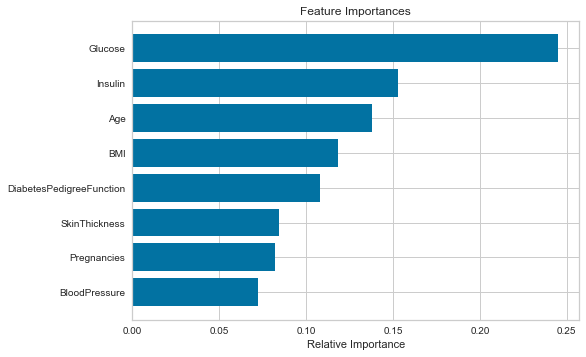

(394, 8)


In [59]:
data_directory = "data/"
filename = "diabetes.csv"
df = pd.read_csv(data_directory + filename)

print(X.shape)
RFC_X = RFC_features(X, y, df.columns[:-1])
print(RFC_X.shape)
